# Introduction

- [1. Loading of datasets](#Load-datasets)
- [2. Transformation of datasets](#Transform-datasets)
- [3. Helper functions](#Helper-functions)
- [4. Manual EMANN](#Manual-EMANN)
    - [4.1 EM Starts Here !](#EM-Starts-Here-!)
- [5. ReGenerate data](#ReGenerate-data)


[**[Back to top]**](#Introduction)

In [2]:
from __future__ import division, print_function
import sys
if '..' not in sys.path:
    sys.path.append('..')

import theano
import theano.tensor as T
import lasagne

import time
import visual

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix, pairwise_distances

from nn.helper import CNN, NN
from nn import block as nnb
from nn import compilers as nnc


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
Using gpu device 0: GeForce GT 750M (CNMeM is disabled, CuDNN 3007)


In [3]:
%matplotlib inline

# Load datasets

- the datasets are loaded/built.
- The batchsize is defined
- half of the data name (the source part) is defined

[**[Back to top]**](#Introduction)

## Datasets Imports 

In [4]:
from datasets.toys import make_clouds, make_circles, make_X, make_moons
from datasets.utils import make_dataset


# Transform datasets

- the transformed datasets are built.
- last part of the data name (the target part) is defined

[**[Back to top]**](#Introduction)

## Transformation Imports

In [5]:
from datasets.utils import make_domain_dataset, make_corrector_dataset
import datasets.transform as transform

# Helper functions

[**[Back to top]**](#Introduction)

In [5]:
# Import the solvers functions
from opt_transport import opt_transp_sup, computeTransportSinkhorn, computeTransportSinkhornLabelsLpL1
# Import loggers
from logs import new_logger, empty_logger
logger = new_logger()

In [6]:
def mass(k_means):
    """
    Params
    ------
        k_means: (sklearn.cluster.KMeans instance)
    Return
    ------
        w: (numpy.array [n_clusters]) the mass of each clusters 
    """
    w = np.unique(k_means.labels_, return_counts=True)[1]
    w = w/np.sum(w)
    return w
    

In [7]:
from align_learn.preprocess import align

def train_dataset(X_src, X_tgt, k_means_src, k_means_tgt, transp):
    """
    
    Params
    ------
        X_src:
        X_tgt:
        k_means_src:
        k_means_tgt:
        transp:
        
    Return
    ------
        X:
        Y:
    """
    align_idx, cluster_T = align(transp, k_means_src.labels_, k_means_tgt.labels_)
    X_S, y_S = X_src, y_src
    X_T, y_T = X_tgt[align_idx], y_tgt[align_idx]
    # Build the probabilities to be predict
    # For the source data
    proba_src = np.zeros((X_S.shape[0], k_means_src.n_clusters))
    proba_src[np.arange(X_S.shape[0]), k_means_src.labels_] = 1.
    proba_tgt = transp[k_means_src.labels_]
    proba_tgt = proba_tgt / np.sum(proba_tgt, 1).reshape(-1, 1)
    Y_S = np.hstack([proba_src, proba_tgt])
    
    # Build the probabilities to be predict
    # For the aligned target data
    proba_tgt = np.zeros((X_T.shape[0], k_means_tgt.n_clusters))
    proba_tgt[np.arange(X_T.shape[0]), cluster_T] = 1.
    proba_src = transp[:, cluster_T].T
    proba_src = proba_src / np.sum(proba_src, 1).reshape(-1, 1)
    Y_T = np.hstack([proba_src, proba_tgt])
    
    Y = np.vstack([Y_S, Y_T])
    X = np.vstack([X_S, X_T])
    return X, Y

# Manual EMANN

[**[Back to top]**](#Introduction)

In [8]:
EM_ITER = 0

**Generate data**

In [9]:
n_classes_1 = 4
n_classes_2 = 4
n_samples = 1000
X_src, y_src = make_clouds(n_samples=n_samples, n_classes=n_classes_1)

# X_tgt, y_tgt = make_clouds(n_samples=n_samples, n_classes=n_classes_1)
X_tgt, y_tgt = make_circles(n_samples=n_samples,  n_classes=n_classes_2)

data_name='Clouds -> Same'

**Clusters**

In [10]:
from sklearn.cluster import KMeans

k_src = 10
k_tgt = 10
# We do not need to have the same number of cluster in the source and target data.
k_means_src = KMeans(n_clusters=k_src).fit(X_src)
k_means_tgt = KMeans(n_clusters=k_tgt).fit(X_tgt)
# Mass and cost matrix
w_src = mass(k_means_src)
w_tgt = mass(k_means_tgt)

**Random cost Matrix**

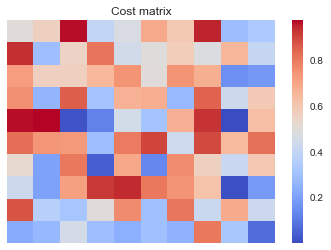

In [11]:
cost_mat = np.random.uniform(0,1, size=(w_src.shape[0], w_tgt.shape[0]))
visual.mat(cost_mat)
plt.title("Cost matrix")
plt.show()

**Pairwise euclidean distance cost matrix**

**Optimal Transport**

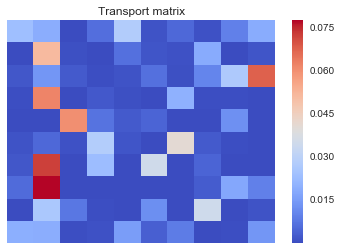

In [12]:
transp = computeTransportSinkhorn(w_src, w_tgt, cost_mat, reg=10)
visual.mat(transp)
plt.title("Transport matrix")
plt.show()

**Dual Proba dataset**

In [101]:
X, Y = train_dataset(X_src, X_tgt, k_means_src, k_means_tgt, transp)
data = make_dataset(X, Y, batchsize=100)

**Neural Network Architecture**

In [102]:
# Get general information :
# =========================
batchsize = data.batchsize
_shape = np.shape(data.X_train)
n_dim = len(_shape)
n_features = np.prod(_shape[1:])

shape = (batchsize,) + _shape[1:]
target_var = T.ivector('targets')

# Logs
logger.info('Building the input and output variables for : {}'.format(data_name))
logger.info('Input data expected shape : {}'.format(shape))

# WARNING :: Une seule couche de proba. On prédit les ligne pas les colonnes !
# Build the layers :
# ==================
def build():
    input_layer = lasagne.layers.InputLayer(shape=shape)

    dense_1 = lasagne.layers.DenseLayer(input_layer, 3, nonlinearity=lasagne.nonlinearities.sigmoid)
    dense_2 = lasagne.layers.DenseLayer(dense_1, 3, nonlinearity=lasagne.nonlinearities.sigmoid)

    # With concat :
    cluster_src = lasagne.layers.DenseLayer(dense_2, k_src, nonlinearity=lasagne.nonlinearities.softmax)
    cluster_tgt = lasagne.layers.DenseLayer(dense_2, k_tgt, nonlinearity=lasagne.nonlinearities.softmax)
    concat_layer = lasagne.layers.ConcatLayer([cluster_src, cluster_tgt], axis=1)

    end_layer = concat_layer
    return end_layer, dense_2
end_layer, repr_layer = build()

[11:16:27] INFO    : Building the input and output variables for : Clouds -> Same
[11:16:27] INFO    : Input data expected shape : (100, 2)


**Compile the NN**

In [103]:
# Instanciate the NN :
# ====================
# nn = NN(end_layer, name='EMANN test')
nn = CNN(name='EMANN test')
nn.add_output('proba', end_layer)
nn.add_output('repr', repr_layer)

# Compile :
# =========
nn.compile('proba', nnc.crossentropy_sgd_mom, lr=0.1, mom=0.9)
nn.compile('proba', nnc.crossentropy_validation)
nn.compile('proba', nnc.output)
nn.compile('repr', nnc.output)


**Train the NN**

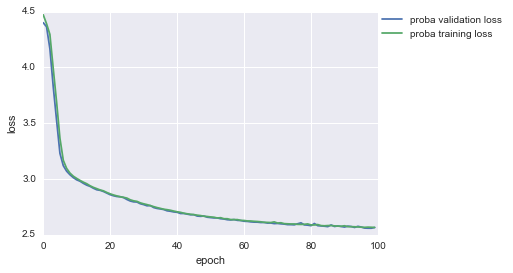

In [104]:
# Train the nn :
# ==============
# nn.train(data, num_epochs=100);
nn.train([data], ['proba'], num_epochs=100);

# ================
# Learning curve
# ================
fig, ax = visual.learning_curve(nn.global_stats, regex='loss')
#     SAVE
# fig.tight_layout()
# fig.savefig(fig_title+'-Learning_curve.png',bbox_inches='tight')
fig.show()

Check

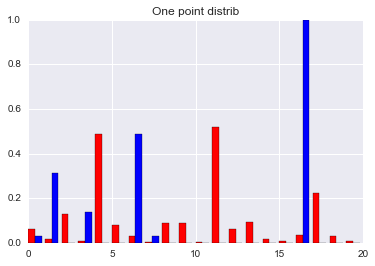

In [105]:
y_pred = nn.parts['proba'].output(data.X_test)[0]
i = np.random.randint(0, data.X_test.shape[0])
# print('\n'.join('{:1.5f}--{:1.5f}'.format(pred, truth) for pred, truth in zip(y_pred[i], data.y_test[i])))
width=0.4
plt.bar(np.arange(k_src+k_tgt), y_pred[i], width, color='r')
plt.bar(np.arange(k_src+k_tgt)+width, data.y_test[i], width, color='b')
plt.title("One point distrib")
plt.legend(bbox_to_anchor=(1.2,1.))
# plt.yscale('log')
plt.show()

## **EM Starts Here !**

[**[Back to top]**](#Introduction)

**Clusters**

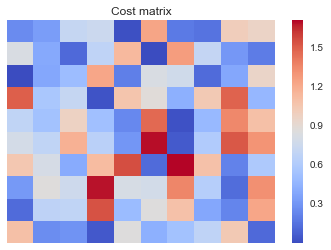

In [131]:
centers_src = nn.parts['repr'].output(k_means_src.cluster_centers_)[0]
centers_tgt = nn.parts['repr'].output(k_means_tgt.cluster_centers_)[0]
cost_mat = pairwise_distances(centers_src, centers_tgt)
cost_mat = cost_mat**2
visual.mat(cost_mat)
plt.title("Cost matrix")
plt.show()

**Optimal Transport**

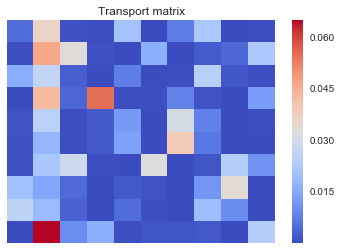

In [132]:
transp = computeTransportSinkhorn(w_src, w_tgt, cost_mat, reg=5)
visual.mat(transp)
plt.title("Transport matrix")
plt.show()

**Dual Proba dataset**

In [133]:
X, Y = train_dataset(X_src, X_tgt, k_means_src, k_means_tgt, transp)
data = make_dataset(X, Y, batchsize=100)

**Neural network** (re-initialization)

**Train the NN**

Iteration n* 7


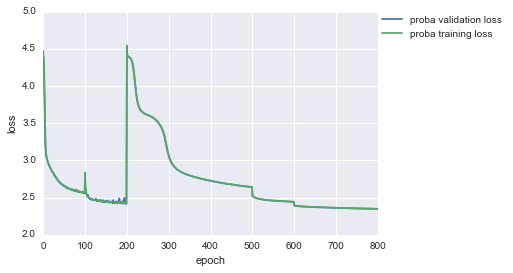

In [134]:
# Train the nn :
# ==============
# nn.train(data, num_epochs=100);
nn.train([data], ['proba'], num_epochs=100);
# ================
# Learning curve
# ================
fig, ax = visual.learning_curve(nn.global_stats, regex='loss')
#     SAVE
# fig.tight_layout()
# fig.savefig(fig_title+'-Learning_curve.png',bbox_inches='tight')
fig.show()

EM_ITER += 1
print('Iteration n*', EM_ITER)

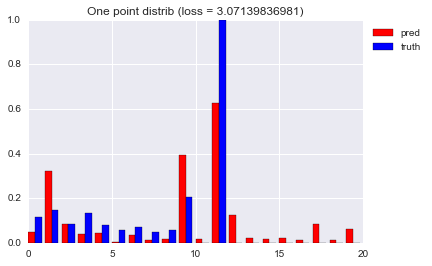

In [135]:
y_pred = nn.parts['proba'].output(data.X_test)[0]
i = np.random.randint(0, data.X_test.shape[0])
# print('\n'.join('{:1.5f}--{:1.5f}'.format(pred, truth) for pred, truth in zip(y_pred[i], data.y_test[i])))
width = 0.4
plt.bar(np.arange(k_src+k_tgt), y_pred[i], width, color='r', label='pred')
plt.bar(np.arange(k_src+k_tgt)+width, data.y_test[i], width, color='b', label='truth')
# plt.yscale('log')
plt.title("One point distrib (loss = "+str(-np.sum(data.y_test[i]*np.log(y_pred[i])))+")")
plt.legend(bbox_to_anchor=(1.2,1.))
plt.show()

[**[EM LOOP]**](#EM-Starts-Here-!)

# ReGenerate data

[**[Back to top]**](#Introduction)